In [36]:
import torch
import dsutils
import easydict
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
import lightning as L
import albumentations as A
from transformers import AutoImageProcessor, AutoModel
import telepix_utils
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [37]:
cfg = easydict.EasyDict(
    model_name = '/hdd1/ysyoon/models/seggpt_vit-large/',
    batch_size = 4,
    num_training_steps = 100000
)

In [38]:
RESUME = 20000
DEVICES = list(range(8))
MODEL_NAME = '/hdd1/ysyoon/models/seggpt_vit-large' if RESUME == -1 else f'ckpts/{RESUME:06d}'

BATCH_SIZE = 4
ROOT_DIR = '/hdd1/ysyoon/datasets/'
DATASET_NAMES = [
    'aihub-landcover-satellite-all',
    'aihub-satellite-object-cloud',
    'eorssd',
    'isaid',
    'open-earth-map',
    'orsi-sod'
]
AUGMENT = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussNoise(p=0.5),
    A.Blur(p=0.5),
])
WEIGHT_DECAY = 0.01
LR = 1e-5
BETAS = [0.9, 0.999]
NUM_TRAINING_STEPS = 100000


In [39]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, dataset_names, augment, image_processor):
        self.root_dir = root_dir
        self.dataset_names = dataset_names
        self.augment = augment
        self.image_processor = image_processor

        self.num_datasets = len(self.dataset_names)
        self.image_paths = [sorted(glob(f'{root_dir}/{dname}/post/train/images/*')) for dname in dataset_names]
        self.num_images = [len(paths) for paths in self.image_paths]

    def __len__(self):
        return sum(self.num_images)

    def transform(self,x):
        custom_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512)),    
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[1, 1, 1])  
        ])
        y = custom_transform(x)
        
        return y

    def __getitem__(self, idx):
        ds_idx = np.random.randint(self.num_datasets)
        image_paths = self.image_paths[ds_idx]
        
        while True:
            image_path = image_paths[np.random.randint(self.num_images[ds_idx])]
            label_path = image_path.replace('/images/', '/labels/')
            
            image = np.array(Image.open(image_path))
            label = np.array(Image.open(label_path))

            unique_classes = np.unique(label)
            unique_classes = unique_classes[unique_classes>0]
            if len(unique_classes) > 0:
                break

        aug1 = self.augment(image=image, mask=label)
        image1, label1 = aug1['image'], aug1['mask']

        aug2 = self.augment(image=image, mask=label)
        image2, label2 = aug2['image'], aug2['mask']

        c = np.random.choice(unique_classes)
        label1 = np.where(label1==c, 1, 0)
        label2 = np.where(label2==c, 1, 0)
        
        palette = [[0,0,0], [255,255,255]]
        label1 = dsutils.segmentation.visualize_label(label1, palette)
        label2 = dsutils.segmentation.visualize_label(label2, palette)

        #------- edge
        edge = telepix_utils.label_to_edge(label1, 3)
        edge = torch.tensor(edge)
        edge = edge.unsqueeze(0)
        edge = edge.double()

        return image1, label1, image2, label2, edge

    def collate_fn(self, batch):
        prompt_images, prompt_labels, input_images, input_labels, edges = zip(*batch)
        batch = self.image_processor(prompt_images, prompt_labels, input_images, input_labels, return_tensors='pt')
        batch['masks'] = self.image_processor.generate_mask(len(prompt_images))
        batch['edges'] = torch.stack([i for i in edges])
        return batch


In [40]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussNoise(p=0.5),
    A.Blur(p=0.5),
])

root_dir = '/hdd1/ysyoon/datasets/'
dataset_names = [
    'aihub-landcover-satellite-all',
    'aihub-satellite-object-cloud',
    'eorssd',
    'isaid',
    'open-earth-map',
    'orsi-sod'
]

In [41]:
def get_param_groups(model, weight_decay):
    no_decay = ["bias", "bn", "ln", "norm"]
    param_groups = [
        {
            # apply weight decay
            "params": [p for n, p in model.named_parameters() if not any(nd in n.lower() for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {
            # not apply weight decay
            "params": [p for n, p in model.named_parameters() if any(nd in n.lower() for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    return param_groups



In [42]:
#--- SegGPT

seg_gpt = AutoModel.from_pretrained(cfg.model_name, trust_remote_code=True)

In [43]:
#--- EdgeNet

class Edge_Net(nn.Module):
    def __init__(self):
        super(Edge_Net, self).__init__()
        #-- edge layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))       
        
        return x1,x2,x3

#------------------------
edge_net = Edge_Net()

# Path to the saved model weights
model_path = "./tmp_ckpts/edge_net_epoch_layer_change_10.pt"  # Adjust this path as needed

# Load the saved model weights
edge_net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
class CombinedModel(nn.Module):
    def __init__(self, model1, model2):
        super(CombinedModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        
        # edge_net freeze
        for param in self.model2.parameters():
            param.requires_grad = False           
    
    def forward(self, batch ):

        #---------
        labels = batch['labels']
        labels = F.interpolate(labels,(512,512),mode='nearest')
        labels = labels.float()
        
        #----------
        edge_gt = batch['edges'] 
        edge_gt = edge_gt.float()
        
        batch.pop('edges',None)
        outputs = self.model1(**batch)

        batch['edges'] = edge_gt
            
        pred = outputs.preds[:,:, 448:]
        # resize pred => 512
        pred = F.interpolate(pred,(512,512),mode='nearest')
        pred = pred.float()
        
        
        #perceptual loss from edge_net
        layer_1_out,layer_2_out,layer_3_out = self.model2(pred)
        layer_1_gt ,layer_2_gt ,layer_3_gt  = self.model2(labels)
        loss_1 = torch.nn.functional.l1_loss(layer_1_out, layer_1_gt)
        loss_2 = torch.nn.functional.l1_loss(layer_2_out, layer_2_gt)
        loss_3 = torch.nn.functional.l1_loss(layer_3_out, layer_3_gt)

        #--- loss 
        loss_seg = outputs.loss
        loss_percept = loss_1 + loss_2 + loss_3
        
        return loss_seg,loss_percept


    def infer(self, batch):

        #---------
        labels = batch['labels']
        labels = F.interpolate(labels,(512,512),mode='nearest')
        labels = labels.float()
        
        #----------
        edge_gt = batch['edges'] 
        edge_gt = edge_gt.float()
        
        batch.pop('edges',None)
        outputs = self.model1(**batch)

        return outputs
        

In [10]:
# Define model 
combined_model = CombinedModel(seg_gpt, edge_net)

In [11]:
# Load model 
# few-shot-segmentation-v2/ckpts/seg_edge_v1/segedge_084000
model_path = "../ckpts//seg_edge_v2/segedge_090000"
combined_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [12]:
image_processor = AutoImageProcessor.from_pretrained(cfg.model_name, trust_remote_code=True)
dataset = Dataset(ROOT_DIR, DATASET_NAMES, AUGMENT, image_processor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=dataset.collate_fn)
dataiter = iter(dataloader)
batch = next(dataiter)
# batch.pop('edges',None)
# output1 = seg_gpt(**batch)
# print(output1.keys())

# combined_model = CombinedModel(seg_gpt, edge_net)
# loss_seg,loss_percept = combined_model(batch)

In [13]:
batch.keys()

dict_keys(['images', 'labels', 'masks', 'edges'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(896, 448, 3)
(896, 448, 3)
(896, 448, 3)
(896, 448, 3)


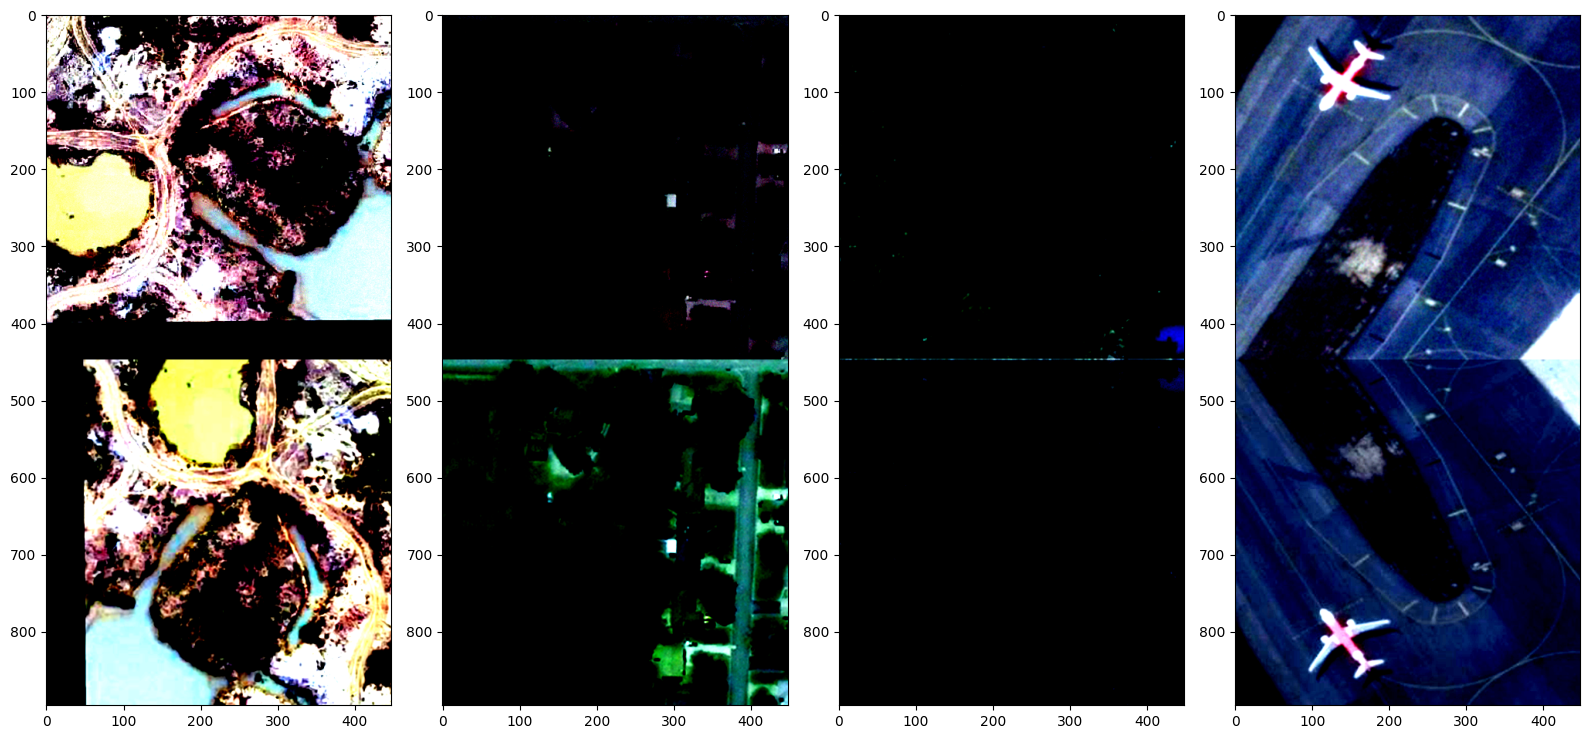

In [14]:
image_processor = AutoImageProcessor.from_pretrained(cfg.model_name, trust_remote_code=True)
dataset = Dataset(ROOT_DIR, DATASET_NAMES, AUGMENT, image_processor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=dataset.collate_fn)
dataiter = iter(dataloader)
batch = next(dataiter)

labels = batch['images']
labels = labels.permute(0,2,3,1)
labels = labels.detach().numpy()

cols = 4
rows = 1 
fig, axs = plt.subplots(rows,cols,figsize=(16,8))

for i in range(len(labels)):
    img = labels[i].copy()
    print(img.shape)
    axs[i].imshow(img)


plt.tight_layout() 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(896, 448, 3)
(896, 448, 3)
(896, 448, 3)
(896, 448, 3)


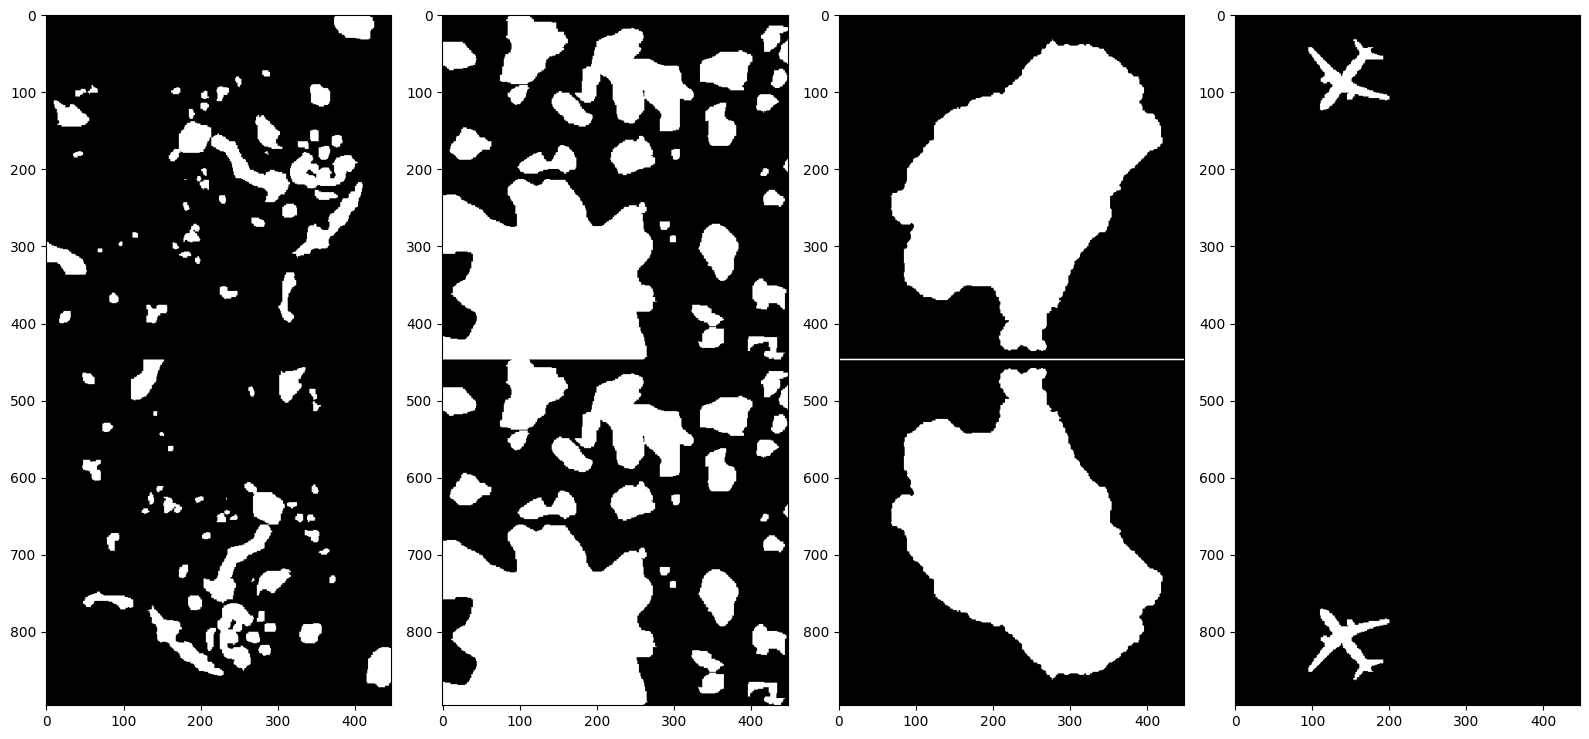

In [15]:
labels = batch['labels']
labels = labels.permute(0,2,3,1)
labels = labels.detach().numpy()

cols = 4
rows = 1 
fig, axs = plt.subplots(rows,cols,figsize=(16,8))

for i in range(len(labels)):
    img = labels[i].copy()
    img =  img[:,:,:]
    print(img.shape)
    axs[i].imshow(img)


plt.tight_layout() 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(896, 448, 3)
(896, 448, 3)
(896, 448, 3)
(896, 448, 3)


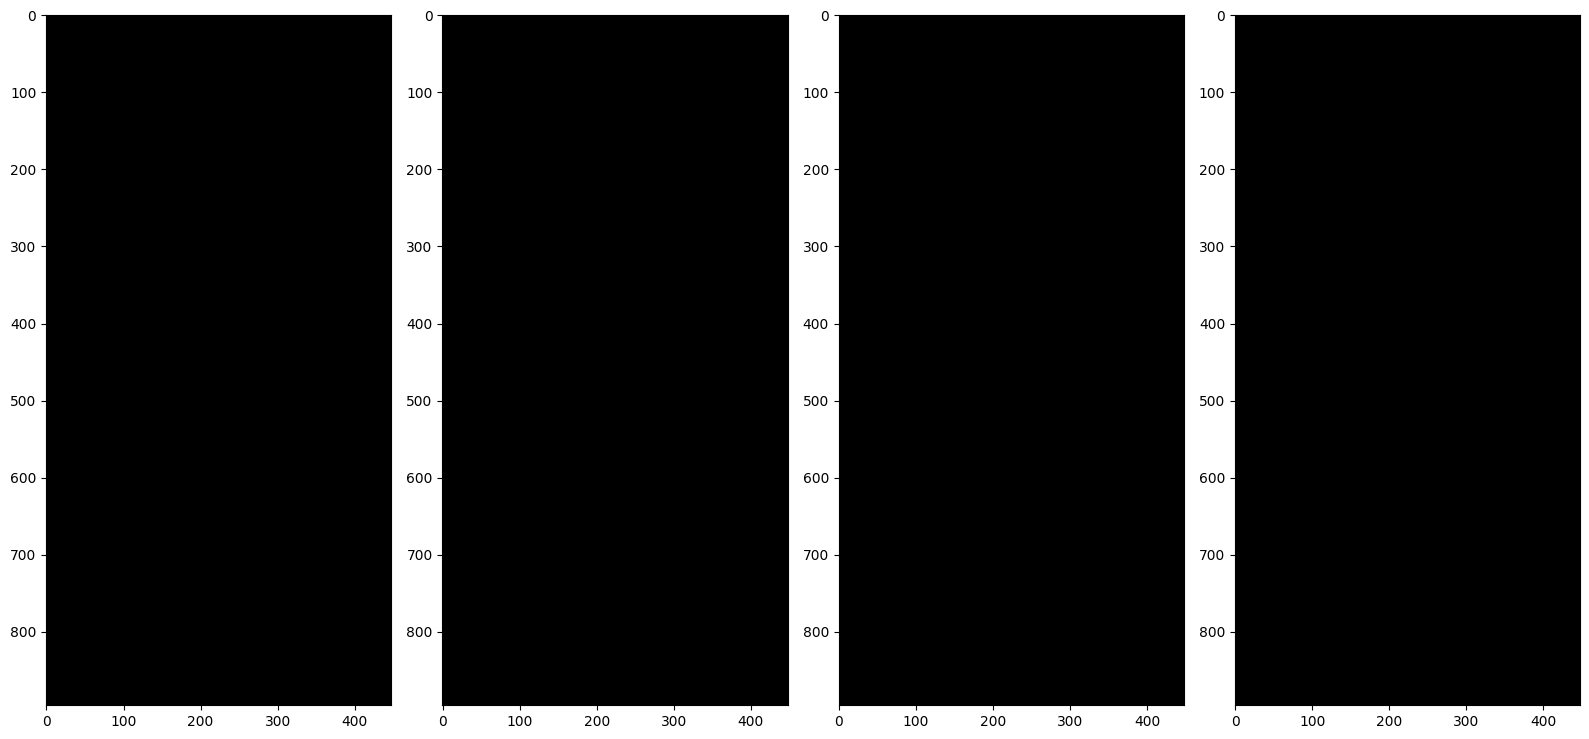

In [16]:
# Define model 
combined_model = CombinedModel(seg_gpt, edge_net)
# Load model 
# few-shot-segmentation-v2/ckpts/seg_edge_v1/segedge_084000
model_path = "../ckpts/seg_edge_v3/segedge_060000"
combined_model.load_state_dict(torch.load(model_path))
aa = combined_model.infer(batch)


labels = aa['preds'].clone()
labels = labels.permute(0,2,3,1)
labels = labels.detach().numpy()


cols = 4
rows = 1 
fig, axs = plt.subplots(rows,cols,figsize=(16,8))

for i in range(len(labels)):
    img = labels[i].copy()
    img =  img[:,:,:]
    print(img.shape)
    axs[i].imshow(img)


plt.tight_layout() 
plt.show()

In [25]:
labels.shape

(4, 896, 448, 3)

In [26]:
labels[0]

array([[[-2.1155217, -2.0326264, -1.8019168],
        [-2.1148596, -2.0324109, -1.801641 ],
        [-2.1149864, -2.0326204, -1.8017131],
        ...,
        [-2.1151328, -2.0324605, -1.8017242],
        [-2.114955 , -2.03252  , -1.801681 ],
        [-2.1135628, -2.0312996, -1.7993177]],

       [[-2.1181798, -2.0356042, -1.8045355],
        [-2.1183362, -2.0359042, -1.8048493],
        [-2.1183672, -2.0359945, -1.8047844],
        ...,
        [-2.1182172, -2.0357912, -1.8046328],
        [-2.118243 , -2.036033 , -1.8047762],
        [-2.1186821, -2.0367303, -1.8040535]],

       [[-2.1183019, -2.0356941, -1.8046532],
        [-2.1184404, -2.0359771, -1.8049103],
        [-2.1185164, -2.036153 , -1.8048475],
        ...,
        [-2.1182108, -2.0358014, -1.8045974],
        [-2.1182764, -2.0360124, -1.804715 ],
        [-2.1187594, -2.0369093, -1.804031 ]],

       ...,

       [[-2.1186028, -2.0360405, -1.8048077],
        [-2.1185644, -2.0361583, -1.8050004],
        [-2.118613 , -

In [27]:
qa = (az - np.min(az)) / (np.max(az) - np.min(az))

In [28]:
qa

array([[[0.01476674, 0.27305317, 0.99190164],
        [0.01682969, 0.2737247 , 0.9927611 ],
        [0.01643448, 0.27307174, 0.9925364 ],
        ...,
        [0.01597835, 0.2735702 , 0.9925018 ],
        [0.01653255, 0.27338448, 0.99263626],
        [0.02087015, 0.2771872 , 1.        ]],

       [[0.00648451, 0.26377472, 0.98374236],
        [0.00599718, 0.2628402 , 0.9827648 ],
        [0.00590061, 0.26255867, 0.9829668 ],
        ...,
        [0.00636788, 0.26319233, 0.98343927],
        [0.00628763, 0.26243907, 0.9829924 ],
        [0.00491927, 0.26026616, 0.985244  ]],

       [[0.00610414, 0.26349467, 0.9833758 ],
        [0.00567254, 0.26261288, 0.98257446],
        [0.00543556, 0.26206464, 0.98277026],
        ...,
        [0.00638792, 0.26316038, 0.9835495 ],
        [0.00618363, 0.26250297, 0.98318297],
        [0.00467858, 0.25970826, 0.98531425]],

       ...,

       [[0.00516665, 0.2624153 , 0.9828943 ],
        [0.00528626, 0.2620483 , 0.9822937 ],
        [0.00513471, 0

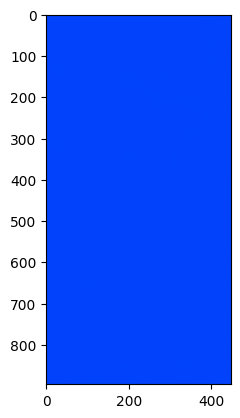

In [29]:
plt.imshow(qa)